## lstm

### 라이브러리

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
# %matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import datetime

### 데이터 로드

In [27]:
# 현재 경로 표시하기
/pwd

'/content/drive/MyDrive/bigdata_project/data'

In [28]:
# 왼쪽 폴더 아이콘 누른 뒤 3번째 아이콘 눌러서 구글 드라이브를 마운트하고 
# 다운 받은 엑셀파일이 저장된 경로를 찾아 들어가야 함
cd drive/MyDrive/bigdata_project/data

[Errno 2] No such file or directory: 'drive/MyDrive/bigdata_project/data'
/content/drive/MyDrive/bigdata_project/data


In [29]:
# 현재 경로 파일 리스트
ls

datareader_finbert_to_num_v2.xlsx
datareader_finbert_to_num.xlsx
datareader_finbert.xlsx
naver_finance_news.xlsx
naver_news.xlsx
preprocessed_dup_eliminated_dataset_finBERT.xlsx
report.xlsx


In [44]:
# 로우 데이터로 엑셀파일 로드
# 실행 전에 미리 구글 드라이브 마운트를 해야하고 동일 경로에서 엑셀파일을 읽어들여야 함
raw_data = pd.read_excel('datareader_finbert_to_num_v2.xlsx')
raw_data = raw_data.set_index("Date")
raw_data

,Open,High,Low,Close,Volume,Change,sentiment,Next_day
Date,,,,,,,,
2021-06-01,80500,81300,80100,80600,14058401,0.001242,1,80800
2021-06-02,80400,81400,80300,80800,16414644,0.002481,0,82800
2021-06-03,81300,83000,81100,82800,29546007,0.024752,0,82200
2021-06-04,82700,82700,81500,82200,18112259,-0.007246,0,81900
2021-06-07,82700,82800,81600,81900,16496197,-0.003650,0,81900
...,...,...,...,...,...,...,...,...
2022-05-31,67500,67500,66700,67400,24365002,-0.004431,0,66700
2022-06-02,66600,67000,66400,66700,14959443,-0.010386,0,66800
2022-06-03,67200,67300,66800,66800,8222883,0.001499,0,65500


### X, y 설정

             Open   High    Low  Close
Date                                  
2021-06-01  80500  81300  80100  80600
2021-06-02  80400  81400  80300  80800
2021-06-03  81300  83000  81100  82800
2021-06-04  82700  82700  81500  82200
2021-06-07  82700  82800  81600  81900
...           ...    ...    ...    ...
2022-05-31  67500  67500  66700  67400
2022-06-02  66600  67000  66400  66700
2022-06-03  67200  67300  66800  66800
2022-06-07  66200  66400  65400  65500
2022-06-08  65400  65700  65300  65300

[252 rows x 4 columns]
            Next_day
Date                
2021-06-01     80800
2021-06-02     82800
2021-06-03     82200
2021-06-04     81900
2021-06-07     81900
...              ...
2022-05-31     66700
2022-06-02     66800
2022-06-03     65500
2022-06-07     65300
2022-06-08     65200

[252 rows x 1 columns]


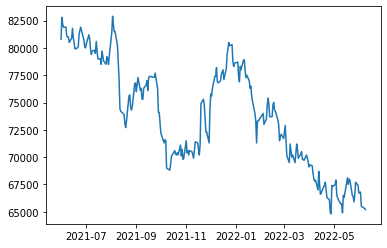

In [45]:
raw_X = raw_data.iloc[:, :4] # base 모델로 시, 고, 저, 종가만 추가했음
raw_y = raw_data.iloc[:, 7:8] # 다음날 종가 데이터가 들어있음
# 과거 데이터로 다음날 종가 데이터를 예측하는 lstm 모델을 만들 것임

print(raw_X)
print(raw_y)

plt.plot(raw_y, label = 'samsung')
plt.show()

### 전처리

In [32]:
# X, y 데이터를 0~1 사이 값으로 정규화 
# 학습이 잘되기 위해 하는 것이고, 이 값은 추후 inverse로 도로 되돌림
sc = MinMaxScaler()
sc_X = sc.fit_transform(raw_X)
sc_y = sc.fit_transform(raw_y)

train_size = int(len(sc_y) * 0.67)
test_size = len(sc_y) - train_size

# 텐서화? 하기
dataX = Variable(torch.Tensor(np.array(sc_X)))
dataY = Variable(torch.Tensor(np.array(sc_y)))

# train 데이터 2/3으로 자르기
trainX = Variable(torch.Tensor(np.array(sc_X[0:train_size])))
trainY = Variable(torch.Tensor(np.array(sc_y[0:train_size])))

# test 데이터 나머지 1/3으로 자르기
testX = Variable(torch.Tensor(np.array(sc_X[train_size:len(sc_X)])))
testY = Variable(torch.Tensor(np.array(sc_y[train_size:len(sc_y)])))

In [33]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

torch.Size([168, 4])
torch.Size([84, 4])
torch.Size([168, 1])
torch.Size([84, 1])


In [34]:
# lstm 모델에 적용할 때 shape을 변경해줘야 함 
# reshape(a, (b,1,c)) 형태로 모델에 돌리기 위해 2차원으로 바꿔주는 것임

trainX_fin = torch.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX_fin = torch.reshape(testX, (testX.shape[0], 1, testX.shape[1])) 

dataX_fin = torch.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
print("Training Shape", trainX_fin.shape, trainY.shape)
print("Testing Shape", testX_fin.shape, testY.shape) 
print(dataX_fin.shape, dataY.shape)

Training Shape torch.Size([168, 1, 4]) torch.Size([168, 1])
Testing Shape torch.Size([84, 1, 4]) torch.Size([84, 1])
torch.Size([252, 1, 4]) torch.Size([252, 1])


### 모델 정의

In [35]:
# 모델 정의하기

class LSTM(nn.Module):
    # Long Short Term Memory
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

# 레이어 추가 예시

# # 모델 만들기

# class LSTM(nn.Module):
#   def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
#     super(LSTM, self).__init__()
#     self.num_classes = num_classes #number of classes
#     self.num_layers = num_layers #number of layers
#     self.input_size = input_size #input size
#     self.hidden_size = hidden_size #hidden state
#     self.seq_length = seq_length #sequence length
 
#     self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
#                       num_layers=num_layers, batch_first=True) #lstm
#     self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
#     self.fc = nn.Linear(128, num_classes) #fully connected last layer

#     self.relu = nn.ReLU() 

#   def forward(self,x):
#     h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
#     c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state   
#     # Propagate input through LSTM

#     output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
#     hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
#     out = self.relu(hn)
#     out = self.fc_1(out) #first Dense
#     out = self.relu(out) #relu
#     out = self.fc(out) #Final Output
   
#     return out 


# print()

In [36]:
num_epochs = 2000
learning_rate = 0.01

input_size = 4 # 컬럼 개수
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, trainX_fin.shape[1])

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm.forward(trainX_fin)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = loss_function(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.48286
Epoch: 100, loss: 0.01456
Epoch: 200, loss: 0.00340
Epoch: 300, loss: 0.00328
Epoch: 400, loss: 0.00318
Epoch: 500, loss: 0.00308
Epoch: 600, loss: 0.00299
Epoch: 700, loss: 0.00291
Epoch: 800, loss: 0.00284
Epoch: 900, loss: 0.00278
Epoch: 1000, loss: 0.00273
Epoch: 1100, loss: 0.00270
Epoch: 1200, loss: 0.00267
Epoch: 1300, loss: 0.00265
Epoch: 1400, loss: 0.00263
Epoch: 1500, loss: 0.00262
Epoch: 1600, loss: 0.00261
Epoch: 1700, loss: 0.00259
Epoch: 1800, loss: 0.00258
Epoch: 1900, loss: 0.00257


### 모델 평가

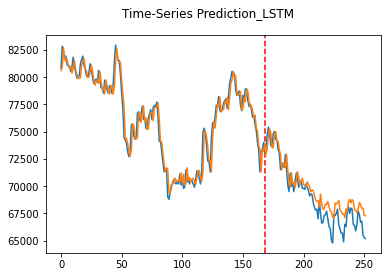

In [37]:
# 모델 평가하기
lstm.eval()

# 학습시킨 모델에 전체 데이터를 적용시켜 Y를 추출한 것
# 전체 데이터의 2/3인 train 데이터까지는 모델 학습에서 사용했던 데이터이고
# 1/3인 test 데이터는 모델이 예측한 값
train_predict = lstm(dataX_fin)

# 전체 데이터 예측 값(Y)을 numpy array로 변경
data_predict = train_predict.data.numpy()

# 실제 Y데이터 값을 numpy array로 변경
dataY_plot = dataY.data.numpy()

# 위에서 모델에 적용하려고 0~1 사이로 정규화했던 값을 다시 inverse
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

# 학습에 사용됐던 데이터와 예측한 값의 경계를 선으로 표현
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction_LSTM')
plt.show()

### 평가지표 구하기

In [38]:
from sklearn.metrics import mean_squared_error

In [39]:
# 예측값: data_predict
# 실제값: dataY_plot

data_predict_fin = list(data_predict.flatten())
dataY_plot_fin = list(dataY_plot.flatten())

In [40]:
score_table = pd.DataFrame({'True': dataY_plot_fin,
                            'Pred': data_predict_fin})

In [41]:
score_table

,True,Pred
0,80800.000000,80581.476562
1,82800.000000,80872.804688
2,82200.000000,82713.843750
3,81900.000000,81600.492188
4,81900.000000,81427.835938
...,...,...
247,66700.000000,68295.640625
248,66800.000000,67961.281250
249,65500.000000,67993.960938
250,65300.003906,67330.437500


In [42]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)

score = 100*(1-(((score_table['Pred']-score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [43]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 1044863.375, RMSE : 1022.1856079101562, SCORE : 99.98097061616136
